<a href="https://colab.research.google.com/github/goldenfries100/171Group14/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
import torch
import torchvision
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras import layers, models
from tensorflow.keras.models import save_model, load_model
import cv2
from mlxtend.evaluate import scoring
import seaborn as sb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
!pip install scikeras

#!pip install selectivesearch

In [9]:
try:
    from google.colab import drive
    IN_COLAB = True
    drive.mount('/content/drive')
    ! git clone https://github.com/goldenfries100/171Group14 data
except:
    IN_COLAB = False
print(IN_COLAB)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'data' already exists and is not an empty directory.
True


In [10]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [11]:
if IN_COLAB:
    head = r'/content/data/'
else:
    head = r'./'
file = head + r'cifar-10-batches-py/batches.meta'
print(file)
batches_meta_file = unpickle(file)
print(batches_meta_file)

data_batch_1_file = head + r'cifar-10-batches-py/data_batch_1'
#dataset_1 = pd.Series(unpickle(data_batch_1_file))
dataset_1 = unpickle(data_batch_1_file)
#The size of the 1st data batch is (10000 , 3072):- It contains 10000 images and each image as 3072 numerical entries:- 1024 for Red, Green, Blue respectively.
image = dataset_1['data'][0]
# In the reshape function, the first argument represent the color scaling we are using, for our case, since we have colored image, therefore the color code is 3. And our each image is of the size 32 x 32 pixels.
image = image.reshape(3,32,32)
# the standard order of the axes is 0, 1, 2 which represents:- width x height x no. of channels.
image = image.transpose(1,2,0)

/content/data/cifar-10-batches-py/batches.meta
{'num_cases_per_batch': 10000, 'label_names': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], 'num_vis': 3072}


(25, 32, 32, 3)
['bird', 'airplane', 'dog', 'deer', 'airplane', 'automobile', 'airplane', 'cat', 'horse', 'horse', 'truck', 'dog', 'airplane', 'frog', 'truck', 'horse', 'automobile', 'frog', 'ship', 'bird', 'bird', 'airplane', 'airplane', 'truck', 'dog']


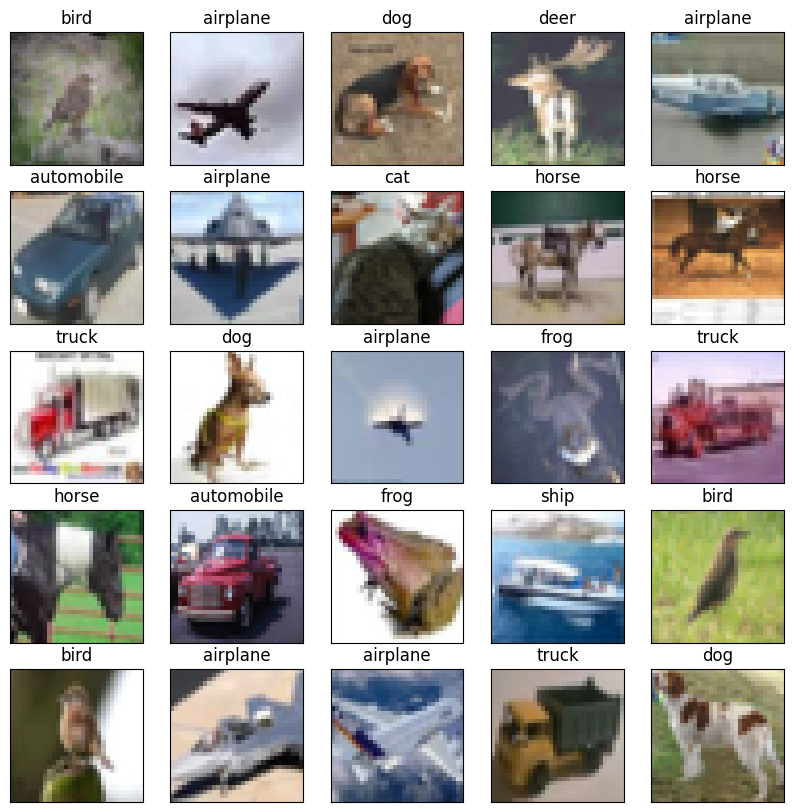

In [5]:
# Python 3 program to visualize 4th image
import matplotlib.pyplot as plt
import numpy as np
# take the images data from batch data
images = dataset_1['data']
# reshape and transpose the images
# the arguments to reshape function are of the form (nb_samples, nb_channels, width, height)
images = images.reshape(len(images),3,32,32).transpose(0, 2, 3, 1)
# take labels of the images
labels = dataset_1['labels']
# label names of the images
label_names = batches_meta_file['label_names']
# display random images
# define row and column of figure
rows, columns = 5, 5
# take random image idex id
imageId = np.random.randint(0, len(images), rows * columns)
# take images for above random image ids
images = images[imageId]
print(images.shape)
# take labels for these images only
labels = [labels[i] for i in imageId]
# define figure
fig=plt.figure(figsize=(10, 10))
# visualize these random images
ln = [label_names[l] for l in labels]
print(ln)
#print(images.shape)
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(label_names[labels[i-1]]))
plt.show()

### EDA(Exploratory Data Analysis)

--- The distribution of data images in dataset  1  --- 
 [1005  974 1032 1016  999  937 1030 1001 1025  981]


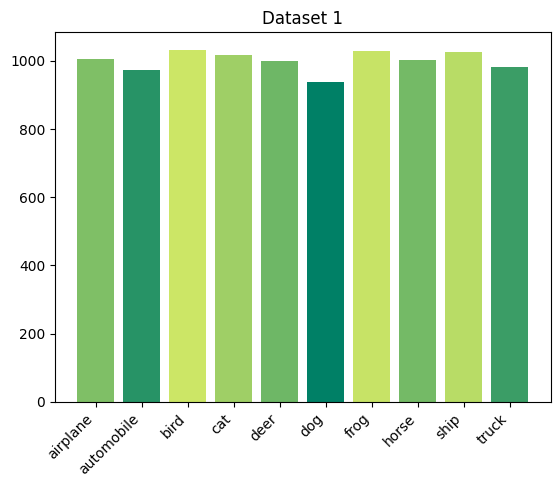

--- The distribution of data images in dataset  2  --- 
 [ 984 1007 1010  995 1010  988 1008 1026  987  985]


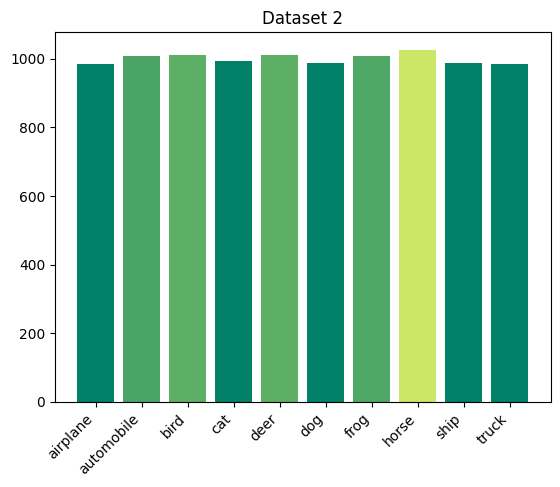

--- The distribution of data images in dataset  3  --- 
 [ 994 1042  965  997  990 1029  978 1015  961 1029]


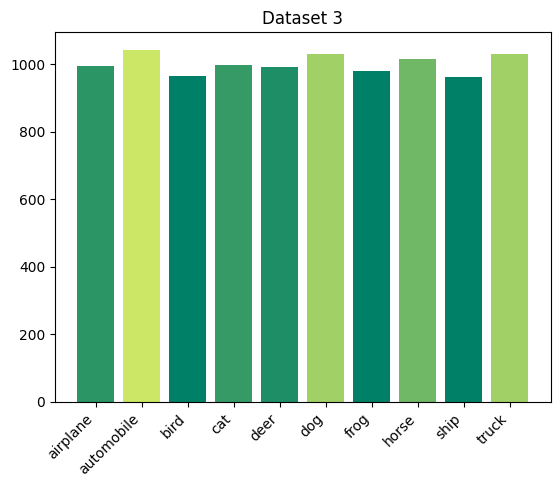

--- The distribution of data images in dataset  4  --- 
 [1003  963 1041  976 1004 1021 1004  981 1024  983]


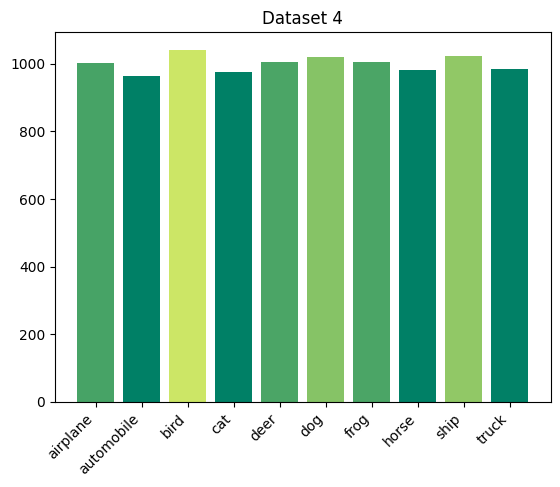

--- The distribution of data images in dataset  5  --- 
 [1014 1014  952 1016  997 1025  980  977 1003 1022]


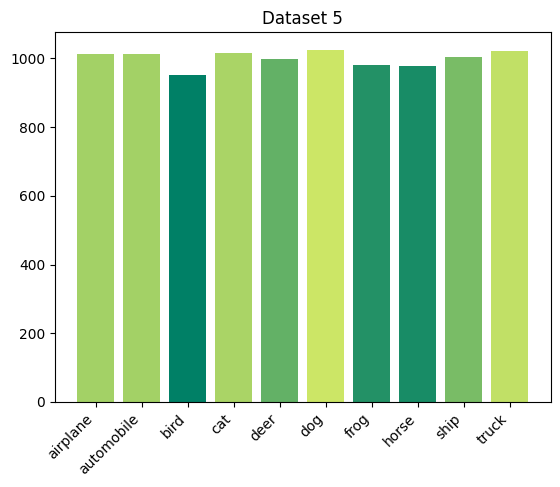

--- The total number of each class in the entire dataset is equal ---


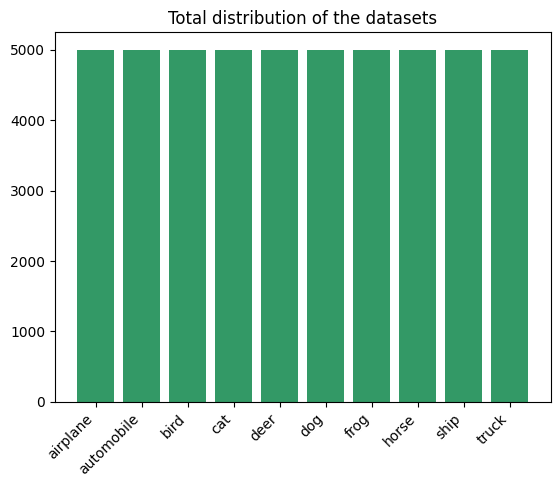

In [12]:
NUM_DATASETS = 5
num_cases_per_batch = batches_meta_file['num_cases_per_batch']
label_names = batches_meta_file['label_names']
# random shuffling of data indices
random_image_indexes = (random.sample(range(num_cases_per_batch), num_cases_per_batch))
# complete dataset array
dataset_array = []
# the primary data in the dataset, contains a 50000 length array of 32x32x3 0-255 RGB values
images = []
# class labels for each image, a 50000 array of ints 0-9 corresponding to indices into label_names
labels = []
# iterate over each dataset
for i in range(NUM_DATASETS):
  # read i-th dataset from file
  dataset_array.append(unpickle(head + f'cifar-10-batches-py/data_batch_{i+1}'))
  # reshape the images into readable RGB pixel format
  dataset_array[i]['data']
  # shuffle the images according to the random image indexes generated above
  images.append(dataset_array[i]['data'][random_image_indexes].reshape(num_cases_per_batch, 3, 32, 32).transpose(0, 2, 3, 1))
  # insert labels into labels list
  labels.append([dataset_array[i]['labels'][random_index] for random_index in random_image_indexes])

# convert to np array
labels = np.asarray(labels)
images = np.asarray(images).reshape(num_cases_per_batch * NUM_DATASETS, 32, 32, 3)
# convert into torch data
training_dataset = torch.from_numpy(images)
training_labels = torch.from_numpy(labels.flatten())

# display the number of occurences of each label in each dataset
cmap = plt.cm.summer
for i in range(NUM_DATASETS):
    counts = np.unique(labels[i], return_counts = True)
    print('--- The distribution of data images in dataset ',i+1,' --- \n', counts[1])
    bars = plt.bar(range(len(counts[0])), counts[1], align='center')
    plt.xticks(range(len(label_names)),label_names)
    plt.xticks(rotation=45, ha='right')
    plt.title('{}' .format('Dataset ' + str(i+1)))
    low = counts[1].min()+5
    high = counts[1].max() - low
    for j, bar in enumerate(bars):
      bar.set_facecolor(cmap((counts[1][j]-low)/high-0.2))
    plt.show()
total_counts = np.unique(labels.flatten(),return_counts = True)
print('--- The total number of each class in the entire dataset is equal ---')
bars = plt.bar(range(len(total_counts[0])),total_counts[1],align='center')
for bar in bars: bar.set_facecolor(cmap(0.2))
plt.xticks(range(len(label_names)),label_names)
plt.xticks(rotation=45, ha='right')
plt.title('Total distribution of the datasets')
plt.show()
### getting the testing images and testing labels.

test_batch_read = head + r'cifar-10-batches-py/test_batch'
test_batch = unpickle(test_batch_read)


test_labels_read = test_batch['labels']
### doing this because image_indexes is a random array of numbers
test_labels_indexed = [test_labels_read[i] for i in random_image_indexes]

test_images = test_batch['data']
test_images = test_images.reshape(num_cases_per_batch, 3, 32, 32).transpose(0, 2, 3, 1)
test_images_indexed = test_images[random_image_indexes]

###CNN

### The first block of code is building the convolutional base for the model.

 So essentially, the CNN model has two parts. One is the convolutional base part in which we try to reduce the number of nodes/parameters whihc will be fed into the neural network. Then the second part is actually building the neural network which predicts the class of the image based on the features.

In [8]:
!pip install visualkeras
import visualkeras
#hyperparameter tuning for the CNN.
def create_model(dropout_1=0.1, dropout_2=0.3, passed_optimizer='adam'):
  cnn_model = models.Sequential()
  cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  cnn_model.add(layers.AveragePooling2D((2, 2)))
  cnn_model.add(layers.Dropout(dropout_1))
  cnn_model.add(layers.Conv2D(96, (3, 3), activation='relu'))
  cnn_model.add(layers.AveragePooling2D((2, 2)))
  cnn_model.add(layers.Conv2D(96, (3, 3), activation='relu'))
  cnn_model.add(layers.Dropout(dropout_2))
  cnn_model.add(layers.Flatten())
  cnn_model.add((layers.Dense(128, activation='relu')))
  cnn_model.add(layers.Dense(10, activation='sigmoid'))
  cnn_model.compile(optimizer=passed_optimizer,
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
  return cnn_model


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 6.8 MB/s eta 0:00:00


In [9]:
base_model = create_model()
base_model.summary()
base_trained_model = base_model.fit(np.array(training_dataset / 255.0), np.array(training_labels), epochs=10, validation_data=(test_images_indexed / 255.0, np.array(test_labels_indexed)))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 average_pooling2d (Average  (None, 15, 15, 64)        0         
 Pooling2D)                                                      
                                                                 
 dropout (Dropout)           (None, 15, 15, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 96)        55392     
                                                                 
 average_pooling2d_1 (Avera  (None, 6, 6, 96)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 96)          8

313/313 [==============================] - 1s 2ms/step


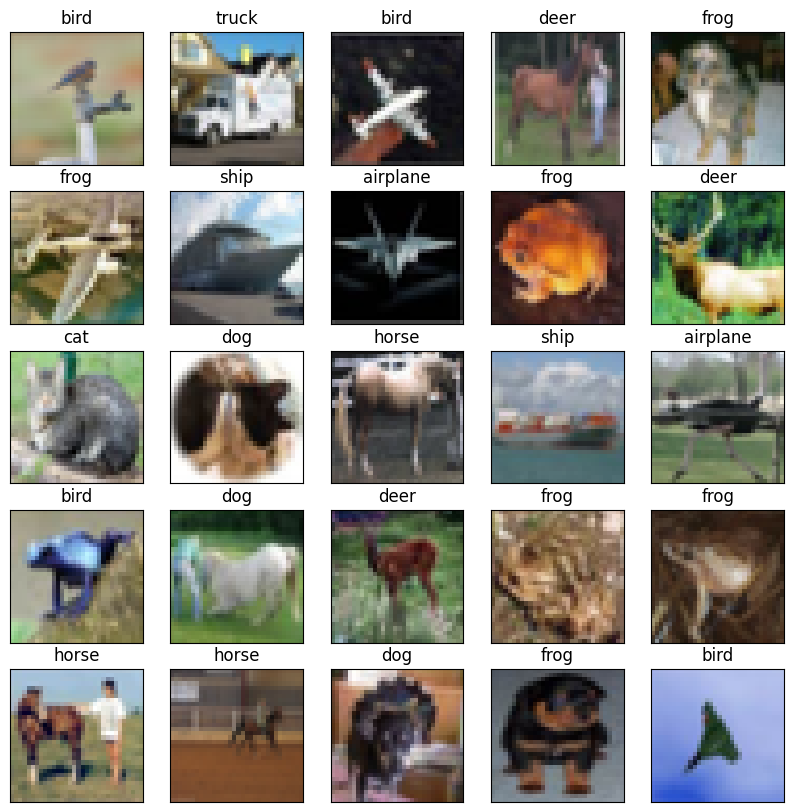

In [10]:
labels_predicted = base_model.predict(test_images_indexed / 255.0)
max_label = [label_names[np.argmax(label)] for label in labels_predicted]

# visualize these random images
fig=plt.figure(figsize=(10, 10))
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(test_images_indexed[i])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(max_label[i]))
plt.show()


In [11]:
base_test_loss, base_test_accuracy = base_model.evaluate(test_images_indexed / 255.0, np.array(test_labels_indexed))

313/313 [==============================] - 1s 3ms/step - loss: 0.8095 - accuracy: 0.7248


The accuracy for the CNN model is:-  72.47999906539917 %
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       941
           1       0.88      0.79      0.83      1124
           2       0.67      0.58      0.62      1166
           3       0.53      0.55      0.54       972
           4       0.65      0.70      0.67       934
           5       0.52      0.71      0.60       728
           6       0.83      0.74      0.78      1127
           7       0.78      0.78      0.78       991
           8       0.86      0.81      0.83      1065
           9       0.77      0.81      0.79       952

    accuracy                           0.72     10000
   macro avg       0.72      0.73      0.72     10000
weighted avg       0.73      0.72      0.73     10000



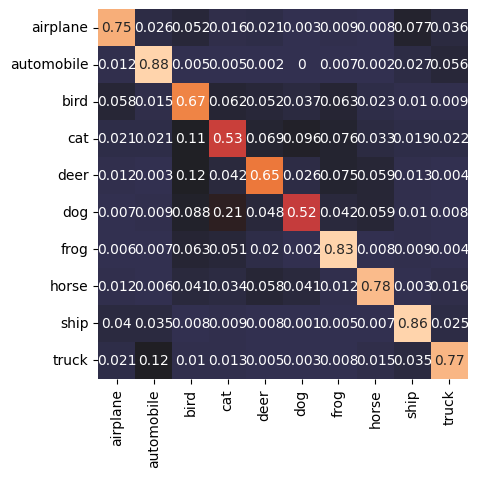

In [12]:
index_of_possible_labels = []
for i in range(num_cases_per_batch):
  index_max = list(labels_predicted[i]).index(max(labels_predicted[i]))
  index_of_possible_labels.append(index_max)
print('The accuracy for the CNN model is:- ', base_test_accuracy * 100, '%')
matrix = confusion_matrix(np.array(test_labels_indexed), index_of_possible_labels, normalize='true')
sb.heatmap(matrix, robust=True, center=0.15, annot=True, xticklabels=label_names, yticklabels=label_names,cbar=False, square=True)
print(classification_report(index_of_possible_labels, np.array(test_labels_indexed)))

In [13]:
!pip install scikeras

In [14]:
from scikeras.wrappers import KerasClassifier
model_1 = KerasClassifier(model=create_model, verbose=0)
parameters = {
     'model__dropout_1': [0.1, 0.2],
     'model__dropout_2': [0.3, 0.4],
     'model__passed_optimizer': ['adam', 'adadelta'],
    #'model__dropout_1': [0.2],
    #'model__dropout_2': [0.3],
    #'model__passed_optimizer': ['adam'],
}
grid = GridSearchCV(estimator=model_1, param_grid=parameters, cv=2, scoring='accuracy', verbose=3)
grid_results = grid.fit(np.array(training_dataset / 255.0), np.array(training_labels), validation_data=(test_images_indexed / 255.0, np.array(test_labels_indexed)))

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END model__dropout_1=0.1, model__dropout_2=0.3, model__passed_optimizer=adam;, score=0.478 total time=  23.1s
[CV 2/2] END model__dropout_1=0.1, model__dropout_2=0.3, model__passed_optimizer=adam;, score=0.463 total time=  15.8s
[CV 1/2] END model__dropout_1=0.1, model__dropout_2=0.3, model__passed_optimizer=adadelta;, score=0.131 total time=  10.1s
[CV 2/2] END model__dropout_1=0.1, model__dropout_2=0.3, model__passed_optimizer=adadelta;, score=0.106 total time=  15.7s
[CV 1/2] END model__dropout_1=0.1, model__dropout_2=0.4, model__passed_optimizer=adam;, score=0.440 total time=  11.0s
[CV 2/2] END model__dropout_1=0.1, model__dropout_2=0.4, model__passed_optimizer=adam;, score=0.466 total time=  15.2s
[CV 1/2] END model__dropout_1=0.1, model__dropout_2=0.4, model__passed_optimizer=adadelta;, score=0.104 total time=  10.4s
[CV 2/2] END model__dropout_1=0.1, model__dropout_2=0.4, model__passed_optimizer=adadelta;, sco

In [15]:
print(grid_results.best_estimator_)
print(grid_results.best_params_)
dp_1, dp_2, best_optimizer= grid_results.best_params_['model__dropout_1'], grid_results.best_params_['model__dropout_2'], grid_results.best_params_['model__passed_optimizer']
# best values
#dp_1, dp_2, best_optimizer = 0.2,0.3,'adam'
print(dp_1, dp_2)

KerasClassifier(
	model=<function create_model at 0x796ba74e5a20>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	model__dropout_1=0.2
	model__dropout_2=0.4
	model__passed_optimizer=adam
	class_weight=None
)
{'model__dropout_1': 0.2, 'model__dropout_2': 0.4, 'model__passed_optimizer': 'adam'}
0.2 0.4


In [16]:
best_model = create_model(dp_1, dp_2, passed_optimizer=best_optimizer)
best_model.summary()
best_model.fit(np.array(training_dataset / 255.0), np.array(training_labels), epochs=10, validation_data=(test_images_indexed / 255.0, np.array(test_labels_indexed)))

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 average_pooling2d_36 (Aver  (None, 15, 15, 64)        0         
 agePooling2D)                                                   
                                                                 
 dropout_36 (Dropout)        (None, 15, 15, 64)        0         
                                                                 
 conv2d_55 (Conv2D)          (None, 13, 13, 96)        55392     
                                                                 
 average_pooling2d_37 (Aver  (None, 6, 6, 96)          0         
 agePooling2D)                                                   
                                                                 
 conv2d_56 (Conv2D)          (None, 4, 4, 96)        

313/313 [==============================] - 1s 2ms/step


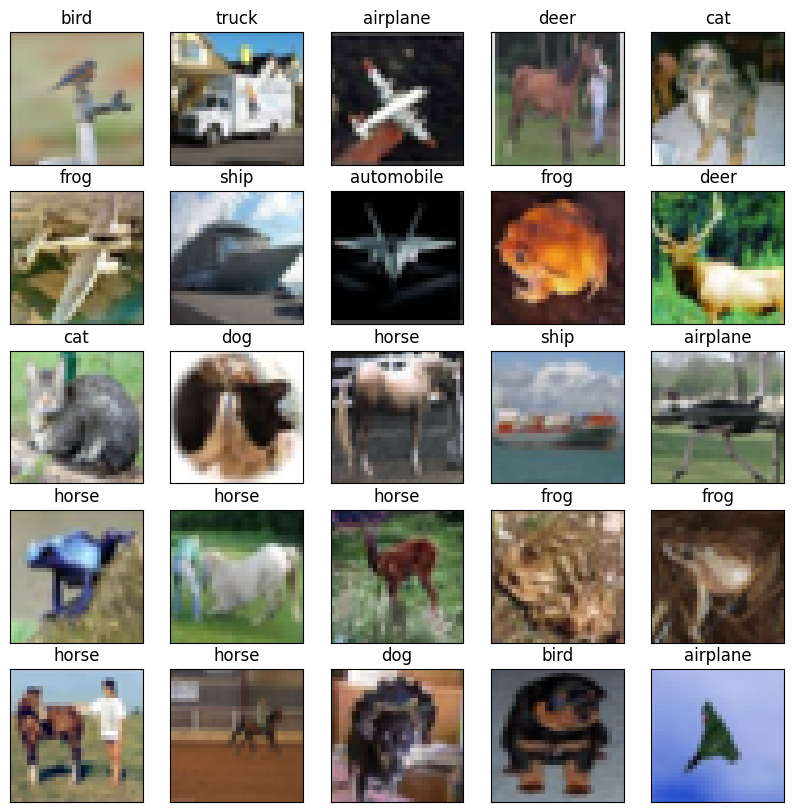

In [17]:
labels_predicted = best_model.predict(test_images_indexed / 255.0)
max_label = [label_names[np.argmax(label)] for label in labels_predicted]

# visualize these random images
fig=plt.figure(figsize=(10, 10))
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(test_images_indexed[i])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(max_label[i]))
plt.show()


In [18]:
test_loss, test_accuracy = best_model.evaluate(test_images_indexed / 255.0, np.array(test_labels_indexed))

313/313 [==============================] - 1s 4ms/step - loss: 0.7678 - accuracy: 0.7329


The accuracy for the CNN model is:-  73.29000234603882 %
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       966
           1       0.87      0.84      0.85      1041
           2       0.69      0.57      0.62      1223
           3       0.61      0.53      0.57      1167
           4       0.65      0.75      0.69       863
           5       0.56      0.72      0.63       774
           6       0.78      0.80      0.79       974
           7       0.77      0.80      0.78       966
           8       0.88      0.77      0.82      1138
           9       0.77      0.86      0.81       888

    accuracy                           0.73     10000
   macro avg       0.73      0.74      0.73     10000
weighted avg       0.74      0.73      0.73     10000



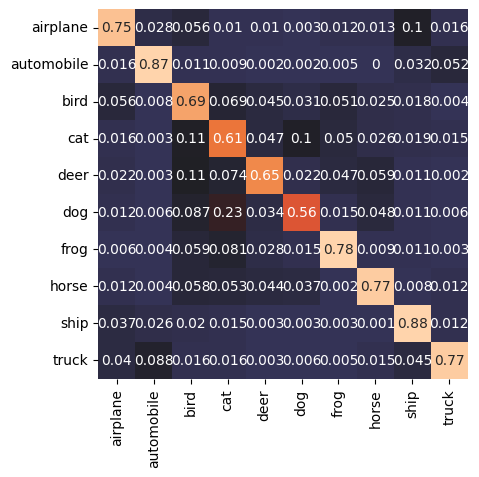

In [19]:
index_of_possible_labels = []
for i in range(num_cases_per_batch):
  index_max = list(labels_predicted[i]).index(max(labels_predicted[i]))
  index_of_possible_labels.append(index_max)
print('The accuracy for the CNN model is:- ', test_accuracy * 100, '%')
matrix = confusion_matrix(np.array(test_labels_indexed), index_of_possible_labels, normalize='true')
sb.heatmap(matrix, robust=True, center=0.15, annot=True, xticklabels=label_names, yticklabels=label_names,cbar=False, square=True)
print(classification_report(index_of_possible_labels, np.array(test_labels_indexed)))

### Naive Bayes Classifier model

In [ ]:
nb = GaussianNB()
image_num, image_height, image_width, scale = training_dataset.shape
nb.fit(np.reshape(training_dataset, newshape=(image_num, image_height * image_width * scale)), np.squeeze(training_labels))

GaussianNB()

The accuracy of the Naive Bayes Classifier for Gaussian pdf is:-  29.759999999999998 %
              precision    recall  f1-score   support

           0       0.49      0.27      0.35      1817
           1       0.17      0.41      0.24       405
           2       0.08      0.19      0.12       443
           3       0.08      0.25      0.12       305
           4       0.42      0.24      0.30      1737
           5       0.26      0.31      0.29       840
           6       0.47      0.25      0.33      1846
           7       0.13      0.42      0.20       310
           8       0.47      0.39      0.42      1219
           9       0.41      0.38      0.39      1078

    accuracy                           0.30     10000
   macro avg       0.30      0.31      0.28     10000
weighted avg       0.39      0.30      0.32     10000



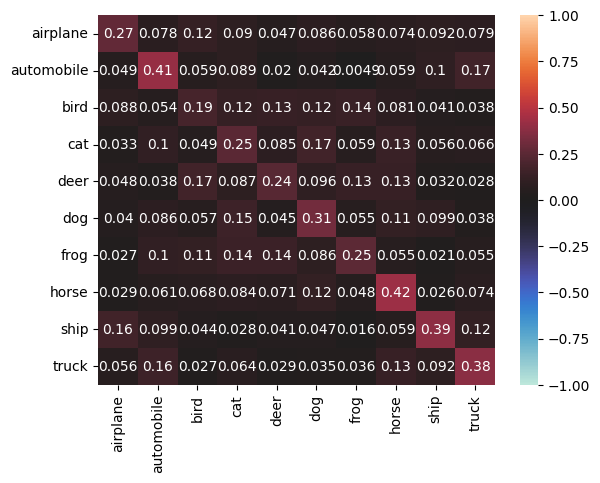

In [ ]:
test_num, test_image_height, test_image_width, scale_test = test_images_indexed.shape
predicted_labels = nb.predict(test_images_indexed.reshape(test_num, test_image_height * test_image_width * scale_test))
print('The accuracy of the Naive Bayes Classifier for Gaussian pdf is:- ', accuracy_score(predicted_labels, test_labels_indexed) * 100, '%')
matrix_nb = confusion_matrix(np.array(predicted_labels), test_labels_indexed, normalize='true')
sb.heatmap(matrix_nb, vmin=-1, vmax=1, center=0, xticklabels=label_names, yticklabels=label_names, annot=True)
print(classification_report(predicted_labels, np.array(test_labels_indexed)))

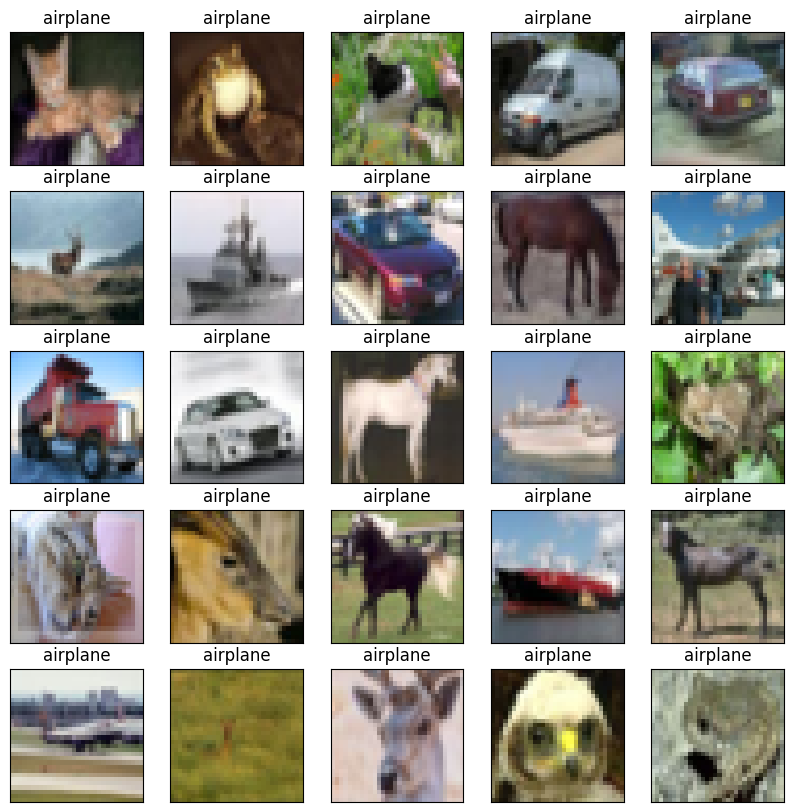

In [ ]:
max_label = []
max_label = [label_names[np.argmax(label)] for label in predicted_labels]
# visualize these random images
fig=plt.figure(figsize=(10, 10))
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(test_images_indexed[i])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(max_label[i]))
plt.show()

### KNN model

In [ ]:
##defines the knn model based on the neighbors and how to weigh each point in our neighborhood.
knn_model = KNeighborsClassifier(n_neighbors=1, weights='uniform')
knn_model.fit(np.reshape(training_dataset, newshape=(image_num, image_height * image_width * scale)), np.squeeze(training_labels))
knn_prediction = knn_model.predict(test_images_indexed.reshape(test_num, test_image_height * test_image_width * scale_test))

              precision    recall  f1-score   support

           0       0.48      0.42      0.45      1144
           1       0.22      0.65      0.33       336
           2       0.38      0.24      0.30      1584
           3       0.24      0.29      0.26       823
           4       0.46      0.25      0.32      1834
           5       0.29      0.36      0.32       798
           6       0.35      0.33      0.34      1075
           7       0.29      0.56      0.39       526
           8       0.62      0.40      0.49      1552
           9       0.20      0.61      0.30       328

    accuracy                           0.35     10000
   macro avg       0.35      0.41      0.35     10000
weighted avg       0.41      0.35      0.36     10000



<Axes: >

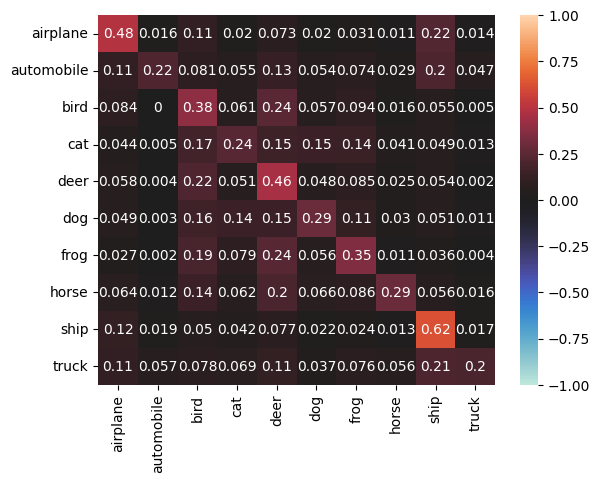

In [ ]:
print(classification_report(knn_prediction, np.array(test_labels_indexed)))
knn_matrix = confusion_matrix(np.array(test_labels_indexed), knn_prediction, normalize='true')
sb.heatmap(knn_matrix, vmin=-1, vmax=1, center=0, annot=True, xticklabels=label_names, yticklabels=label_names)

In [ ]:
parameters = [{
    'n_neighbors': [1, 2, 3],
    'weights': ['uniform', 'distance']
}]

In [ ]:
knn_model_optimized = KNeighborsClassifier()
grid_model = GridSearchCV(estimator=knn_model_optimized, param_grid=parameters, cv=2, return_train_score=True, verbose=3)
grid_model.fit(np.reshape(training_dataset, newshape=(image_num, image_height * image_width * scale)), np.squeeze(training_labels))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.321) total time= 2.1min
[CV 2/2] END n_neighbors=1, weights=uniform;, score=(train=1.000, test=0.320) total time= 2.1min
[CV 1/2] END n_neighbors=1, weights=distance;, score=(train=1.000, test=0.321) total time= 2.1min
[CV 2/2] END n_neighbors=1, weights=distance;, score=(train=1.000, test=0.320) total time= 2.1min
[CV 1/2] END n_neighbors=2, weights=uniform;, score=(train=0.628, test=0.290) total time= 2.1min
[CV 2/2] END n_neighbors=2, weights=uniform;, score=(train=0.611, test=0.285) total time= 2.1min
[CV 1/2] END n_neighbors=2, weights=distance;, score=(train=1.000, test=0.321) total time= 2.0min
[CV 2/2] END n_neighbors=2, weights=distance;, score=(train=1.000, test=0.320) total time= 2.0min
[CV 1/2] END n_neighbors=3, weights=uniform;, score=(train=0.558, test=0.309) total time= 2.1min
[CV 2/2] END n_neighbors=3, weights=uniform;, score=(train=0.56

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [1, 2, 3],
                          'weights': ['uniform', 'distance']}],
             return_train_score=True, verbose=3)

In [ ]:
print(grid_model.best_estimator_)
best_neighbors, best_weights_attribute = grid_model.best_params_['n_neighbors'], grid_model.best_params_['weights']
print(best_neighbors, best_weights_attribute)

KNeighborsClassifier(n_neighbors=3, weights='distance')
3 distance


In [ ]:
best_knn_model = KNeighborsClassifier(n_neighbors=best_neighbors, weights=best_weights_attribute)
best_knn_model.fit(np.reshape(training_dataset, newshape=(image_num, image_height * image_width * scale)), np.squeeze(training_labels))
knn_prediction_optimized = best_knn_model.predict(test_images_indexed.reshape(test_num, test_image_height * test_image_width * scale_test))

              precision    recall  f1-score   support

           0       0.49      0.44      0.46      1126
           1       0.22      0.68      0.33       316
           2       0.39      0.25      0.31      1544
           3       0.22      0.28      0.25       765
           4       0.49      0.25      0.33      1967
           5       0.29      0.39      0.34       749
           6       0.34      0.32      0.33      1057
           7       0.28      0.58      0.38       489
           8       0.65      0.39      0.49      1673
           9       0.20      0.62      0.30       314

    accuracy                           0.36     10000
   macro avg       0.36      0.42      0.35     10000
weighted avg       0.42      0.36      0.36     10000



<Axes: >

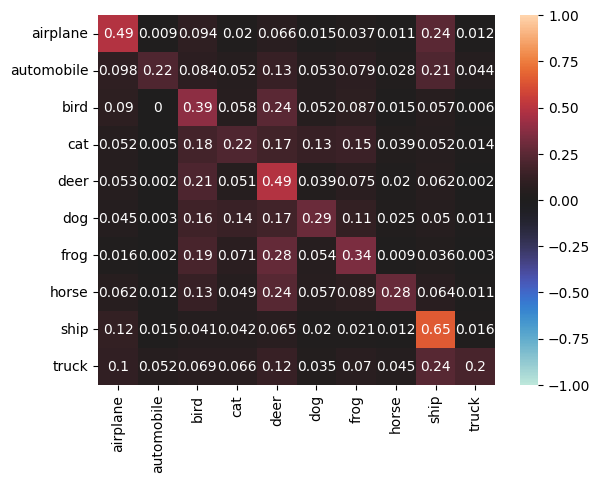

In [ ]:
print(classification_report(knn_prediction_optimized, np.array(test_labels_indexed)))
knn_matrix = confusion_matrix(np.array(test_labels_indexed), knn_prediction_optimized, normalize='true')
sb.heatmap(knn_matrix, vmin=-1, vmax=1, center=0, annot=True, xticklabels=label_names, yticklabels=label_names)

RNN-CNN model

In [19]:
def rnn_cnn(repeated_vector_num = 128, lstm_value=256, passed_optimizer='adam'):
  rnn_cnn_model = models.Sequential()
  rnn_cnn_model.add((layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3))))
  rnn_cnn_model.add((layers.AveragePooling2D((2, 2))))
  rnn_cnn_model.add((layers.Dropout(0.2)))
  rnn_cnn_model.add((layers.Conv2D(96, (3, 3), activation='relu')))
  rnn_cnn_model.add((layers.AveragePooling2D((2, 2))))
  rnn_cnn_model.add((layers.Conv2D(96, (3, 3), activation='relu')))
  rnn_cnn_model.add((layers.Dropout(0.4)))
  rnn_cnn_model.add((layers.Flatten()))
  rnn_cnn_model.add((layers.Dense(128, activation='relu')))
  rnn_cnn_model.add(tf.keras.layers.RepeatVector(repeated_vector_num))
  rnn_cnn_model.add(tf.keras.layers.LSTM(lstm_value))
  rnn_cnn_model.add(layers.Dense(10, activation='sigmoid'))
  rnn_cnn_model.compile(optimizer=passed_optimizer,
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
  return rnn_cnn_model


In [23]:
### label based-resampling for the image
rnn_cnn_model = rnn_cnn()
rnn_cnn_model.summary()
trained_model = rnn_cnn_model.fit(np.array(training_dataset / 255.0), np.array(training_labels), epochs=10, validation_data=(test_images_indexed / 255.0, np.array(test_labels_indexed)))

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 average_pooling2d_40 (Aver  (None, 15, 15, 64)        0         
 agePooling2D)                                                   
                                                                 
 dropout_40 (Dropout)        (None, 15, 15, 64)        0         
                                                                 
 conv2d_61 (Conv2D)          (None, 13, 13, 96)        55392     
                                                                 
 average_pooling2d_41 (Aver  (None, 6, 6, 96)          0         
 agePooling2D)                                                   
                                                                 
 conv2d_62 (Conv2D)          (None, 4, 4, 96)        

In [24]:
base_test_loss, base_test_accuracy_r_cnn = rnn_cnn_model.evaluate(test_images_indexed / 255.0, np.array(test_labels_indexed))

313/313 [==============================] - 2s 7ms/step - loss: 0.8228 - accuracy: 0.7188


313/313 [==============================] - 2s 6ms/step
The accuracy for the CNN model on test data is:-  71.88000082969666 %
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      1054
           1       0.87      0.81      0.84      1073
           2       0.58      0.66      0.62       880
           3       0.49      0.54      0.51       903
           4       0.68      0.64      0.66      1055
           5       0.57      0.67      0.62       855
           6       0.90      0.62      0.73      1444
           7       0.79      0.78      0.78      1008
           8       0.82      0.85      0.84       960
           9       0.70      0.91      0.79       768

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.73      0.72      0.72     10000



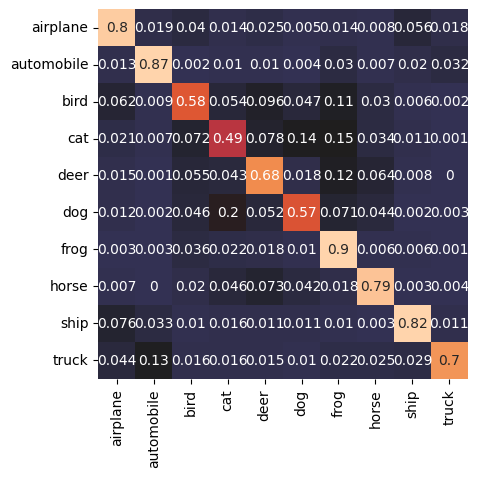

In [25]:
labels_predicted = rnn_cnn_model.predict(test_images_indexed / 255.0)
max_label = [label_names[np.argmax(label)] for label in labels_predicted]
index_of_possible_labels = []
for i in range(num_cases_per_batch):
  index_max = list(labels_predicted[i]).index(max(labels_predicted[i]))
  index_of_possible_labels.append(index_max)
print('The accuracy for the CNN model on test data is:- ', base_test_accuracy_r_cnn * 100, '%')
matrix = confusion_matrix(np.array(test_labels_indexed), index_of_possible_labels, normalize='true')
sb.heatmap(matrix, robust=True, center=0.15, annot=True, xticklabels=label_names, yticklabels=label_names, cbar=False, square=True)
print(classification_report(index_of_possible_labels, np.array(test_labels_indexed)))

In [21]:
from scikeras.wrappers import KerasClassifier
rcmodel = KerasClassifier(model=rnn_cnn, verbose=0)
parameters= {
    'model__repeated_vector_num': [128, 256],
    'model__lstm_value': [256, 512],
    'model__passed_optimizer': ['adam', 'adadelta'],
}
rcgrid = GridSearchCV(estimator=rcmodel, param_grid=parameters, cv=2, scoring='accuracy', verbose=3)

In [22]:
rc_grid_results = rcgrid.fit(np.array(training_dataset / 255.0), np.array(training_labels), validation_data=(test_images_indexed / 255.0, np.array(test_labels_indexed)))

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END model__lstm_value=256, model__passed_optimizer=adam, model__repeated_vector_num=128;, score=0.469 total time=  34.1s
[CV 2/2] END model__lstm_value=256, model__passed_optimizer=adam, model__repeated_vector_num=128;, score=0.448 total time=  22.7s
[CV 1/2] END model__lstm_value=256, model__passed_optimizer=adam, model__repeated_vector_num=256;, score=0.452 total time=  35.1s
[CV 2/2] END model__lstm_value=256, model__passed_optimizer=adam, model__repeated_vector_num=256;, score=0.436 total time=  31.5s
[CV 1/2] END model__lstm_value=256, model__passed_optimizer=adadelta, model__repeated_vector_num=128;, score=0.095 total time=  28.9s
[CV 2/2] END model__lstm_value=256, model__passed_optimizer=adadelta, model__repeated_vector_num=128;, score=0.110 total time=  32.0s
[CV 1/2] END model__lstm_value=256, model__passed_optimizer=adadelta, model__repeated_vector_num=256;, score=0.097 total time=  30.7s
[CV 2/2] END model

In [23]:
# print(rc_grid_results.best_params_)
best_lstm_value, best_rc_optimizer, best_repeated_vector_num = rc_grid_results.best_params_['model__lstm_value'], rc_grid_results.best_params_['model__passed_optimizer'], rc_grid_results.best_params_['model__repeated_vector_num']
#best_lstm_value, best_rc_optimizer, best_repeated_vector_num = 128, 'adam', 256# best params
print(best_lstm_value, best_rc_optimizer, best_repeated_vector_num)

256 adam 128


In [25]:
best_rnn_cnn_model = rnn_cnn(repeated_vector_num=best_repeated_vector_num,
                             lstm_value=best_lstm_value, passed_optimizer=best_rc_optimizer)
trained_model = best_rnn_cnn_model.fit(np.array(training_dataset / 255.0),
                                  np.array(training_labels), epochs=10, validation_data=(test_images_indexed / 255.0, np.array(test_labels_indexed)))

Epoch 1/10
1563/1563 [==============================] - 25s 14ms/step - loss: 1.6134 - accuracy: 0.4045 - val_loss: 1.3466 - val_accuracy: 0.5072
Epoch 2/10
1563/1563 [==============================] - 21s 14ms/step - loss: 1.2723 - accuracy: 0.5450 - val_loss: 1.1484 - val_accuracy: 0.5875
Epoch 3/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.1317 - accuracy: 0.5980 - val_loss: 1.0042 - val_accuracy: 0.6437
Epoch 4/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.0380 - accuracy: 0.6312 - val_loss: 0.9905 - val_accuracy: 0.6535
Epoch 5/10
1563/1563 [==============================] - 21s 14ms/step - loss: 0.9628 - accuracy: 0.6581 - val_loss: 0.9127 - val_accuracy: 0.6778
Epoch 6/10
1563/1563 [==============================] - 21s 13ms/step - loss: 0.8990 - accuracy: 0.6829 - val_loss: 0.8953 - val_accuracy: 0.6850
Epoch 7/10
1563/1563 [==============================] - 21s 14ms/step - loss: 0.8507 - accuracy: 0.6981 - val_loss: 0.8616 -

313/313 [==============================] - 2s 6ms/step - loss: 0.7914 - accuracy: 0.7264
The accuracy for the RNN-CNN model on test data is:-  72.64000177383423 %
              precision    recall  f1-score   support

           0       0.79      0.72      0.75      1099
           1       0.80      0.90      0.85       893
           2       0.63      0.61      0.62      1040
           3       0.50      0.55      0.53       915
           4       0.73      0.65      0.69      1127
           5       0.58      0.67      0.62       866
           6       0.80      0.79      0.80      1012
           7       0.75      0.79      0.77       941
           8       0.87      0.78      0.82      1113
           9       0.81      0.81      0.81       994

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



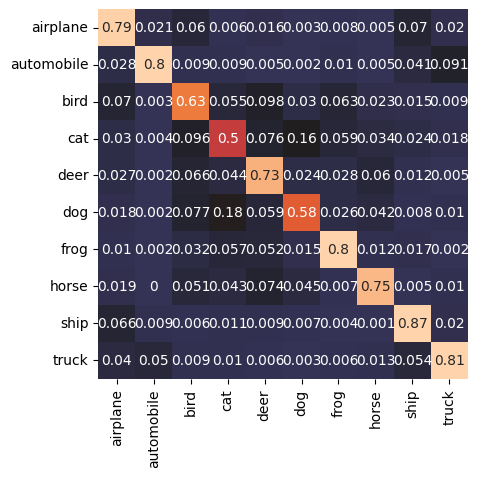

In [28]:
labels_predicted = best_rnn_cnn_model.predict(test_images_indexed / 255.0)
max_label = [label_names[np.argmax(label)] for label in labels_predicted]
index_of_possible_labels = []
for i in range(num_cases_per_batch):
  index_max = list(labels_predicted[i]).index(max(labels_predicted[i]))
  index_of_possible_labels.append(index_max)
test_loss_r_cnn, test_accuracy_r_cnn = best_rnn_cnn_model.evaluate(test_images_indexed / 255.0, np.array(test_labels_indexed))
print('The accuracy for the RNN-CNN model on test data is:- ', test_accuracy_r_cnn * 100, '%')
matrix = confusion_matrix(np.array(test_labels_indexed), index_of_possible_labels, normalize='true')
sb.heatmap(matrix, robust=True, center=0.15, annot=True, xticklabels=label_names, yticklabels=label_names, cbar=False, square=True)
print(classification_report(index_of_possible_labels, np.array(test_labels_indexed)))

In [29]:
best_rnn_cnn_model.save_weights('./rnn_cnn.keras')